In [1]:
# 0. ENVIRONMENT SET‑UP
# ============================================================
# !pip install pandas numpy scikit-learn joblib matplotlib seaborn

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import joblib
sns.set_theme(style="ticks")

In [2]:
# Load CSV
df = pd.read_csv("Water Quality Prediction Dataset.csv", sep=";")  # Adjust path or separator if needed
df.columns = df.columns.str.strip()                # Clean column names

# Parse date
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y", errors="coerce")
df = df.dropna(subset=["date"])  # Remove rows where date couldn't be parsed

# Sort values
df = df.sort_values(["id", "date"])

# Extract year and month
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

pollutants = ["O2", "NO3", "NO2", "SO4", "PO4", "CL"]
df[pollutants] = df[pollutants].apply(lambda col: col.fillna(col.mean()))

# Preview
print(df.head())

   id       date    NH4  BSK5  Suspended     O2    NO3    NO2    SO4    PO4  \
0   1 2000-02-17  0.330  2.77       12.0  12.30   9.50  0.057  154.0  0.454   
1   1 2000-05-11  0.044  3.00       51.6  14.61  17.75  0.034  352.0  0.090   
2   1 2000-09-11  0.032  2.10       24.5   9.87  13.80  0.173  416.0  0.200   
3   1 2000-12-13  0.170  2.23       35.6  12.40  17.13  0.099  275.2  0.377   
4   1 2001-03-02  0.000  3.03       48.8  14.69  10.00  0.065  281.6  0.134   

       CL  year  month  
0   289.5  2000      2  
1  1792.0  2000      5  
2  2509.0  2000      9  
3  1264.0  2000     12  
4  1462.0  2001      3  


In [3]:
# 2. WQI CALCULATION
# ============================================================
ideal  = {"O2": 7.0, "NO3": 0.0, "NO2": 0.0, "SO4": 0.0, "PO4": 0.0, "CL": 0.0}
std    = {"O2": 14.6, "NO3": 45,  "NO2": 3,  "SO4": 250, "PO4": 0.5, "CL": 250}
weight = {"O2": 0.20, "NO3": 0.15, "NO2": 0.15, "SO4": 0.15, "PO4": 0.15, "CL": 0.20}

def qi(c, p):
    return np.clip((c - ideal[p]) / (std[p] - ideal[p]) * 100, 0, 100)

def calc_wqi(row):
    scores = [qi(row[p], p) * weight[p] for p in pollutants]
    return sum(scores) / sum(weight.values())

df["WQI"] = df.apply(calc_wqi, axis=1)

def wqi_class(wqi):
    if wqi <= 25:  return "Excellent"
    if wqi <= 50:  return "Good"
    if wqi <= 75:  return "Poor"
    return "Not Suitable"

df["WQI_Class"] = df["WQI"].apply(wqi_class)

In [4]:
# 3. FEATURE & TARGET PREPARATION
# ============================================================
X_raw = df[["id", "year"]]
y = df[pollutants].astype(float)
X_encoded = pd.get_dummies(X_raw, columns=["id"], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# 4. MODEL TRAINING
# ============================================================
reg = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
)
reg.fit(X_train_scaled, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42))

In [6]:
# 5. REGRESSION PERFORMANCE (Per Pollutant)
# ============================================================
y_pred = reg.predict(X_test_scaled)

print("\n=== Per-Pollutant Performance on Test Set ===")
for i, p in enumerate(pollutants):
    print(f"{p:<4} | MSE: {mean_squared_error(y_test.iloc[:, i], y_pred[:, i]):9.3f} "
          f"| R²: {r2_score(y_test.iloc[:, i], y_pred[:, i]):6.3f}")


=== Per-Pollutant Performance on Test Set ===
O2   | MSE:    22.930 | R²:  0.005
NO3  | MSE:    17.418 | R²:  0.529
NO2  | MSE:     5.223 | R²: -6.567
SO4  | MSE:  2626.531 | R²:  0.335
PO4  | MSE:     0.447 | R²:  0.351
CL   | MSE: 34464.952 | R²:  0.731


<Figure size 600x400 with 0 Axes>

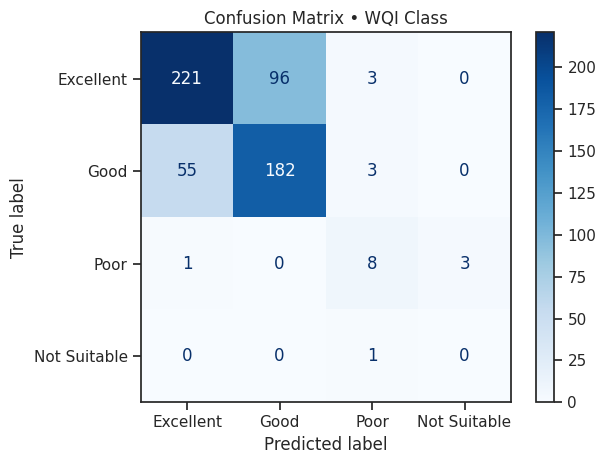


WQI Class Accuracy: 0.7173


In [7]:
# 6. WQI CONFUSION MATRIX & ACCURACY
# ============================================================
true_wqi = y_test.copy()
true_wqi["WQI"] = y_test.apply(lambda r: calc_wqi(r), axis=1)
true_class = true_wqi["WQI"].apply(wqi_class)

pred_df = pd.DataFrame(y_pred, columns=pollutants)
pred_df["WQI"] = pred_df.apply(lambda r: calc_wqi(r), axis=1)
pred_class = pred_df["WQI"].apply(wqi_class)

labels_order = ["Excellent", "Good", "Poor", "Not Suitable"]
cm = confusion_matrix(true_class, pred_class, labels=labels_order)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix • WQI Class")
plt.tight_layout()
plt.show()

# Accuracy calculation
acc = accuracy_score(true_class, pred_class)
print(f"\nWQI Class Accuracy: {acc:.4f}")

In [8]:
# 7. RANDOM SAMPLE EVALUATION
# ============================================================
def evaluate_random_samples(n_samples=5):
    idx = random.sample(range(len(df)), n_samples)
    rows = df.iloc[idx].reset_index(drop=True)

    X_small = pd.get_dummies(rows[["id", "year"]], columns=["id"])
    for col in X_encoded.columns:
        if col not in X_small: X_small[col] = 0
    X_small = X_small[X_encoded.columns]
    X_small_scaled = scaler.transform(X_small)

    preds = reg.predict(X_small_scaled)

    for i in range(n_samples):
        print(f"\n------ SAMPLE {i+1} ------")
        print(f"Station: {rows.loc[i,'id']} | Year: {rows.loc[i,'year']}")
        print("Actual vs Predicted (mg/L)")
        for j, p in enumerate(pollutants):
            print(f"  {p:<3}:  {rows.loc[i,p]:7.2f}  |  {preds[i,j]:7.2f}")

        true_wqi = calc_wqi(rows.loc[i, pollutants])
        pred_wqi = calc_wqi(dict(zip(pollutants, preds[i])))
        print(f"True  WQI : {true_wqi:6.2f} → {wqi_class(true_wqi)}")
        print(f"Pred. WQI : {pred_wqi:6.2f} → {wqi_class(pred_wqi)}")

# Example execution
evaluate_random_samples()


------ SAMPLE 1 ------
Station: 15 | Year: 2010
Actual vs Predicted (mg/L)
  O2 :     4.90  |     7.12
  NO3:     0.58  |     2.99
  NO2:     0.02  |     0.05
  SO4:    29.80  |    35.95
  PO4:     0.34  |     0.32
  CL :    20.80  |    24.23
True  WQI :  13.93 → Excellent
Pred. WQI :  15.38 → Excellent

------ SAMPLE 2 ------
Station: 22 | Year: 2011
Actual vs Predicted (mg/L)
  O2 :    20.73  |    10.73
  NO3:     9.25  |     5.30
  NO2:     0.06  |     0.07
  SO4:   153.60  |   105.16
  PO4:     0.02  |     0.27
  CL :    65.23  |    53.12
True  WQI :  38.35 → Good
Pred. WQI :  30.70 → Good

------ SAMPLE 3 ------
Station: 15 | Year: 2005
Actual vs Predicted (mg/L)
  O2 :    10.60  |    11.26
  NO3:     6.60  |     3.30
  NO2:     0.06  |     0.11
  SO4:    23.10  |    30.76
  PO4:     0.12  |     0.13
  CL :    25.30  |    26.36
True  WQI :  18.98 → Excellent
Pred. WQI :  20.73 → Excellent

------ SAMPLE 4 ------
Station: 20 | Year: 2018
Actual vs Predicted (mg/L)
  O2 :    12.75 

In [9]:
# 8. SAVE MODEL & PREPROCESSORS
# ============================================================
joblib.dump(reg, "RF1_multi_rf_pollutant_model.pkl")
joblib.dump(scaler, "RF1_feature_scaler.pkl")
joblib.dump(X_encoded.columns.tolist(), "RF1_model_features.pkl")
print("\n✔ Model and preprocessing objects saved successfully.")


✔ Model and preprocessing objects saved successfully.
